In [5]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from dataloaders.bouncing_data import BouncingBallDataLoader
from torch.utils.data import DataLoader
from models.KalmanVAE import KalmanVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_square_black_white_small/train')
train_loader = DataLoader(dl, batch_size=4, shuffle=True, num_workers=4)
obs_dim = next(iter(train_loader))[1].size(-1)
im, y = next(iter(train_loader))
print(im.size())

torch.Size([4, 50, 1, 32, 32])


In [23]:
kvae = KalmanVAE(1,128,2,4,3,1).float().cuda()
print(kvae)
checkpoint = torch.load('/data2/users/cb221/stored_models/KVAE_mitigate_rec_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])

KalmanVAE(
  (encoder): CNNFastEncoder(
    (in_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (out_mean): Linear(in_features=512, out_features=2, bias=True)
    (out_log_var): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): CNNFastDecoder(
    (in_dec): Linear(in_features=2, out_features=512, bias=True)
    (hidden_convs): ModuleList(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (parameter_net): MLP(
    (fc1): Linear(in_features=2, out_features=50, bias=True)
    (fc2): L

<All keys matched successfully>

In [26]:
x_hat, a_mu, _, losses = kvae((im[:,:20] > 0.5).float().cuda())

In [30]:
kvae._kalman_posterior(a_mu, filter_only=True)[0][1][:,0]

tensor([[[ 1.9999e+01, -1.1640e-03, -9.8865e-03, -1.9081e-03],
         [-1.1640e-03,  1.9996e+01, -1.5081e-02, -2.4793e-03],
         [-9.8865e-03, -1.5081e-02,  1.9869e+01, -2.5392e-02],
         [-1.9081e-03, -2.4793e-03, -2.5392e-02,  1.9995e+01]],

        [[ 8.0183e-02,  6.5117e-05, -8.4901e-05, -6.8216e-05],
         [ 6.5117e-05,  8.0581e-02,  1.4750e-04, -1.8906e-05],
         [-8.4901e-05,  1.4750e-04,  8.0201e-02, -6.4224e-05],
         [-6.8216e-05, -1.8906e-05, -6.4224e-05,  8.0116e-02]],

        [[ 8.0001e-02,  1.7076e-07, -4.9422e-07, -3.2760e-07],
         [ 1.7076e-07,  8.0003e-02,  4.3984e-07,  9.5897e-08],
         [-4.9422e-07,  4.3984e-07,  7.9999e-02, -6.8072e-07],
         [-3.2760e-07,  9.5897e-08, -6.8072e-07,  8.0000e-02]],

        [[ 8.0001e-02,  1.6729e-07, -4.9513e-07, -3.2565e-07],
         [ 1.6729e-07,  8.0003e-02,  4.3426e-07,  9.8900e-08],
         [-4.9513e-07,  4.3426e-07,  7.9999e-02, -6.7968e-07],
         [-3.2565e-07,  9.8900e-08, -6.7968e-07, 

In [15]:
for i in range(4):
    plt.scatter(a_mu[i,:,0],a_mu[i,:,1], s=10)

NameError: name 'a_mu' is not defined

(100, 100)
torch.Size([100, 100, 2])


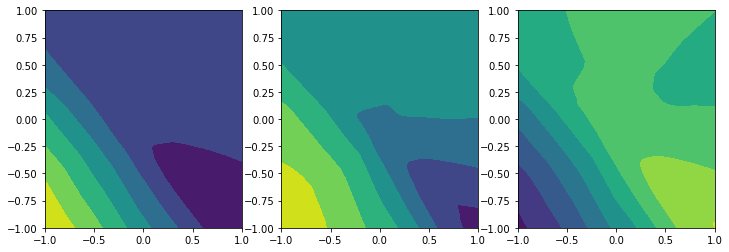

In [4]:
N = 100
xlist = np.linspace(-1, 1, N)
ylist = np.linspace(-1, 1, N)
X, Y = np.meshgrid(xlist, ylist)
print(X.shape)
X_t = torch.from_numpy(X).unsqueeze(-1)
Y_t = torch.from_numpy(Y).unsqueeze(-1)
dom = torch.cat([X_t,Y_t], dim=-1).float()
print(dom.size())
Z = kvae.parameter_net(dom.reshape(-1, 2)).softmax(-1).reshape(N,N,-1).detach().numpy()
fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    cp = ax.contourf(X, Y, Z[:,:,i])
plt.show()

In [ ]:
kvae.predict_sequence